In [2]:
spark = (SparkSession.builder
         .appName("TugasPertemuan9")
         .config("spark.ui.showConsoleProgress", "false")
         .getOrCreate())
spark.sparkContext.setLogLevel("ERROR")

import logging
logging.getLogger("py4j").setLevel(logging.ERROR)
logging.getLogger("pyspark").setLevel(logging.ERROR)



25/10/29 11:16:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+---------+-----------+-------------+
| DeptName|TotalSalary|EmployeeCount|
+---------+-----------+-------------+
|  Finance|       9200|            2|
|Marketing|       7600|            2|
|       HR|       5700|            2|
+---------+-----------+-------------+



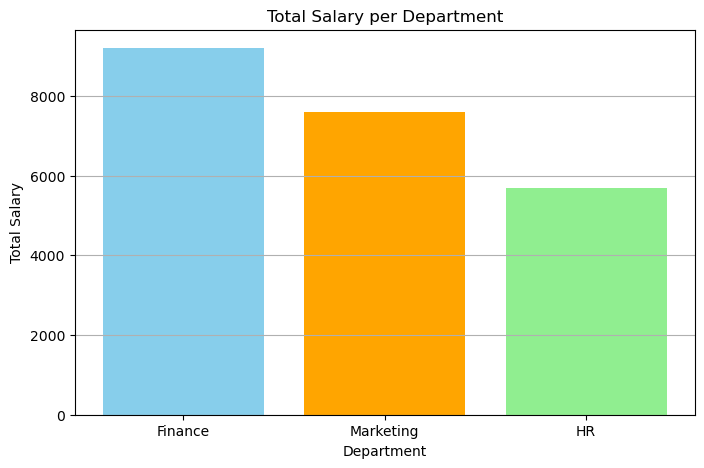

In [3]:
# Tugas 1

from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

# Inisialisasi Spark
spark = SparkSession.builder.appName("Tugas_Pertemuan9").getOrCreate()

# Dataset dasar
employees_data = [
    ('Artur', 34, 'M', 3000, 1),
    ('Bella', 28, 'F', 4100, 2),
    ('Liam', 23, 'M', 2700, 1),
    ('Diana', 30, 'F', 3500, 2),
    ('Bima', 41, 'M', 5000, 3),
    ('Sita', 25, 'F', 4200, 3)
]
employees_columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']

departments_data = [
    (1, 'HR'),
    (2, 'Marketing'),
    (3, 'Finance')
]
departments_columns = ['DeptId', 'DeptName']

# Membuat DataFrame Spark
employees_df = spark.createDataFrame(employees_data, employees_columns)
departments_df = spark.createDataFrame(departments_data, departments_columns)

# Registrasi sebagai SQL view
employees_df.createOrReplaceTempView("employees")
departments_df.createOrReplaceTempView("departments")

# Query total gaji & jumlah karyawan per departemen
dept_stats = spark.sql('''
SELECT d.DeptName,
       SUM(e.Salary) AS TotalSalary,
       COUNT(e.Name) AS EmployeeCount
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY TotalSalary DESC
''')

dept_stats.show()

# Visualisasi perbandingan total gaji per departemen
dept_pd = dept_stats.toPandas()

plt.figure(figsize=(8,5))
plt.bar(dept_pd['DeptName'], dept_pd['TotalSalary'], color=['skyblue', 'orange', 'lightgreen'])
plt.title('Total Salary per Department')
plt.xlabel('Department')
plt.ylabel('Total Salary')
plt.grid(axis='y')
plt.show()


+-----+---+------+-------------------+
| Name|Age|Salary|           AgeGroup|
+-----+---+------+-------------------+
|Diana| 30|  3500| Mid-Junior (30-40)|
|Bella| 28|  4100|       Junior (<30)|
| Sita| 25|  4200|       Junior (<30)|
+-----+---+------+-------------------+



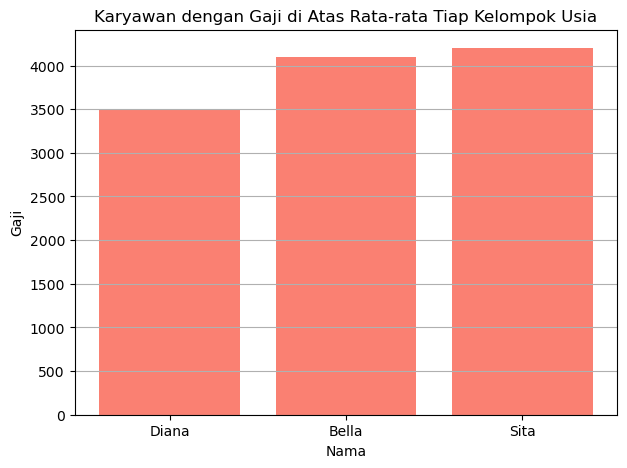

In [5]:
#Tugas 2

# Tambahkan kolom kategori usia
spark.sql('''
SELECT *,
       CASE 
           WHEN Age < 30 THEN 'Junior (<30)'
           WHEN Age BETWEEN 30 AND 40 THEN ' Mid-Junior (30-40)'
           ELSE 'Senior (>40)'
       END AS AgeGroup
FROM employees
''').createOrReplaceTempView("employees_with_agegroup")

# Hitung rata-rata gaji tiap kelompok umur
above_avg = spark.sql('''
SELECT e.Name, e.Age, e.Salary, e.AgeGroup
FROM employees_with_agegroup e
JOIN (
    SELECT AgeGroup, AVG(Salary) AS AvgSalary
    FROM employees_with_agegroup
    GROUP BY AgeGroup
) avg_tbl
ON e.AgeGroup = avg_tbl.AgeGroup
WHERE e.Salary > avg_tbl.AvgSalary
ORDER BY e.AgeGroup
''')

above_avg.show()

# Visualisasi
above_avg_pd = above_avg.toPandas()

plt.figure(figsize=(7,5))
plt.bar(above_avg_pd['Name'], above_avg_pd['Salary'], color='salmon')
plt.title('Karyawan dengan Gaji di Atas Rata-rata Tiap Kelompok Usia')
plt.xlabel('Nama')
plt.ylabel('Gaji')
plt.grid(axis='y')
plt.show()


+---------+--------------+---------+-----------+
| DeptName|TotalEmployees|AvgSalary|TotalSalary|
+---------+--------------+---------+-----------+
|  Finance|            27|  5527.19|     149234|
|       IT|            28|  5457.25|     152803|
|    Sales|            33|  5217.85|     172189|
|Marketing|            29|  5201.45|     150842|
|       HR|            33|  5200.52|     171617|
+---------+--------------+---------+-----------+



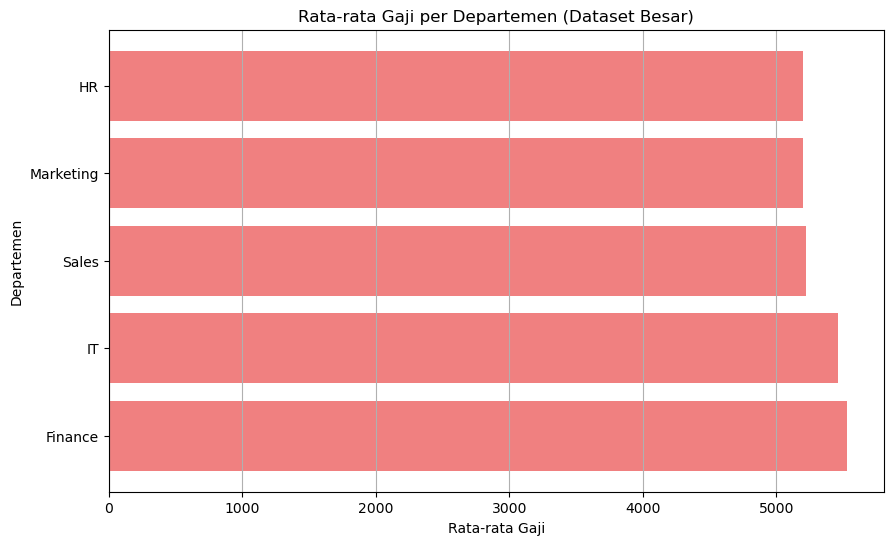

In [6]:
#Tugas 3

import random

# Buat dataset besar (100+)
names = ['Irgi','Alaia','Louis','Ryan','Mikha','Baila','Conor','Nesya','Tommy','Danish']
departments_big = [(1,'HR'), (2,'Marketing'), (3,'Finance'), (4,'IT'), (5,'Sales')]
dept_df_big = spark.createDataFrame(departments_big, ['DeptId','DeptName'])
dept_df_big.createOrReplaceTempView("departments_big")

# Generate 150 data acak
big_data = []
for i in range(150):
    name = random.choice(names)
    age = random.randint(22,55)
    gender = random.choice(['M','F'])
    salary = random.randint(2500,8000)
    deptid = random.randint(1,5)
    big_data.append((name, age, gender, salary, deptid))

big_columns = ['Name','Age','Gender','Salary','DeptId']
big_df = spark.createDataFrame(big_data, big_columns)
big_df.createOrReplaceTempView("employees_big")

# Analisis SQL
big_stats = spark.sql('''
SELECT d.DeptName,
       COUNT(e.Name) AS TotalEmployees,
       ROUND(AVG(e.Salary),2) AS AvgSalary,
       SUM(e.Salary) AS TotalSalary
FROM employees_big e
JOIN departments_big d ON e.DeptId = d.DeptId
GROUP BY d.DeptName
ORDER BY AvgSalary DESC
''')

big_stats.show(10)

# Visualisasi hasil
big_pd = big_stats.toPandas()

plt.figure(figsize=(10,6))
plt.barh(big_pd['DeptName'], big_pd['AvgSalary'], color='lightcoral')
plt.title('Rata-rata Gaji per Departemen (Dataset Besar)')
plt.xlabel('Rata-rata Gaji')
plt.ylabel('Departemen')
plt.grid(axis='x')
plt.show()
